In [1]:
# 准备数据
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers,losses,metrics,optimizers,models
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

print(tf.__version__)

2.1.0


In [2]:
#打印时间分割线
@tf.function
def printbar():
    ts = tf.timestamp()

    # 计算当天时间的秒数，记录的时间的开文天文台的时间
    today_ts = ts%(24*60*60)

    # 计算当前的日期时：需要+8表示当前北京时间
    hour = tf.cast(today_ts//3600+8,tf.int32)%tf.constant(24)
    # 计算分钟
    minite = tf.cast((today_ts%3600)//60,tf.int32)
    # 计算秒钟
    second = tf.cast(tf.floor(today_ts%60),tf.int32)

    # 是否需要在前面加0
    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}",m))==1:
            return(tf.strings.format("0{}",m))
        else:
            return(tf.strings.format("{}",m))

    timestring = tf.strings.join([timeformat(hour),timeformat(minite),
                timeformat(second)],separator = ":")
    tf.print("=========="*5,end = "")
    tf.print(timestring)

In [3]:
# 正负样本数量
n_positive,n_negative = 2000,2000

#生成正样本，小圆环分布
# 圆的半径+随机值
r_p = 5.0 + tf.random.truncated_normal([n_positive,1],0.0,1.0)
# 圆的角度
theta_p = tf.random.uniform([n_positive,1],0.0,2*np.pi)
# 计算圆点的位置，利用tf.concat实现数据的拼接
Xp = tf.concat([r_p*tf.cos(theta_p),r_p*tf.sin(theta_p)],axis=1)
# 标签为1，正样本标签的数据
Yp = tf.ones_like(r_p)

#生成负样本，小圆环分布
# 圆的半径+随机值
r_n = 8.0 + tf.random.truncated_normal([n_negative,1],0.0,1.0)
# 圆的角度
theta_n = tf.random.uniform([n_negative,1],0.0,2*np.pi)
# 计算圆点的位置，tf.concat将数据在列维度上拼接
Xn = tf.concat([r_n*tf.cos(theta_n),r_n*tf.sin(theta_n)],axis=1)
# 标签为0，负样本标签的数据
Yn = tf.zeros_like(r_n)

# 汇总数据
X = tf.concat([Xp,Xn],axis=0)
Y = tf.concat([Yp,Yn],axis=0)

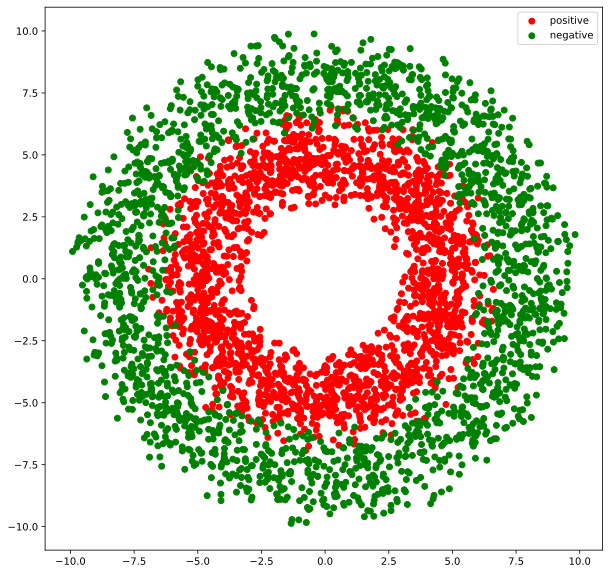

In [7]:
#可视化
plt.figure(figsize = (10,10))
plt.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
plt.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
plt.legend(["positive","negative"])

In [11]:
# 构建管道数据
ds = tf.data.Dataset.from_tensor_slices((X,Y))\
        .shuffle(buffer_size=4000).batch(10)\
        .prefetch(tf.data.experimental.AUTOTUNE)

In [6]:
# 定义模型
class DNNModel(tf.Module):
    def __init__(self,name=None):
        super(DNNModel,self).__init__(name=name)
        self.dense1 = layers.Dense(4,activation="relu")
        self.dense2 = layers.Dense(8,activation="relu")
        self.dense3 = layers.Dense(1,activation="sigmoid")

    # 正向传播/搭建网络
    @tf.function(input_signature=[tf.TensorSpec(shape = [None,2], dtype = tf.float32)])  
    def __call__(self,x):
        x = self.dense1(x)
        x = self.dense2(x)
        y = self.dense3(x)
        return y

model = DNNModel()
model.loss_func = losses.binary_crossentropy
model.metric_func = metrics.binary_accuracy
model.optimizer = optimizers.Adam(learning_rate = 0.001)


In [7]:
(features,labels) = next(ds.as_numpy_iterator())

predictions = model(features)

loss = model.loss_func(tf.reshape(labels,[-1]),tf.reshape(predictions,[-1]))
metric = model.metric_func(tf.reshape(labels,[-1]),tf.reshape(predictions,[-1]))

tf.print("init loss:",loss)
tf.print("init metric",metric)

init loss: 0.779884338
init metric 0.47


In [9]:
# 训练模型
@tf.function
def train_step(model,feature,labels):
    with tf.GradientTape() as tape:
        predictions = model(feature)
        loss = model.loss_func(tf.reshape(labels,[-1]),tf.reshape(predictions,[-1]))

    grads = tape.gradient(loss,model.trainable_variables)
    model.optimizer.apply_gradients(zip(grads,model.trainable_variables))

    metric = model.metric_func(tf.reshape(labels,[-1]), tf.reshape(predictions,[-1]))
    
    return loss,metric


In [12]:
def train_model(model,epochs):
    for epoch in tf.range(1,epochs+1):
        loss, metric = tf.constant(0.0),tf.constant(0.0)
        for features, labels in ds:
            loss,metric = train_step(model,features,labels)
        if epoch%10==0:
            printbar()
            tf.print("epoch =",epoch,"loss = ",loss, "accuracy = ",metric)
train_model(model,epochs = 60)

==================================================08:37:15
epoch = 10 loss =  0.0382410698 accuracy =  1
==================================================08:37:18
epoch = 20 loss =  0.0543511435 accuracy =  1
==================================================08:37:22
epoch = 30 loss =  0.234410793 accuracy =  0.8
==================================================08:37:26
epoch = 40 loss =  0.145888299 accuracy =  0.9
==================================================08:37:30
epoch = 50 loss =  0.329568714 accuracy =  0.7
==================================================08:37:34
epoch = 60 loss =  0.0180308782 accuracy =  1


Text(0.5, 1.0, 'y_pred')

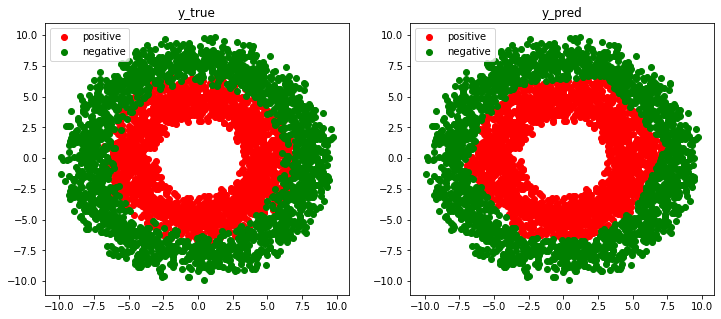

In [13]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
ax1.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
ax1.legend(["positive","negative"])
ax1.set_title("y_true")

Xp_pred = tf.boolean_mask(X,tf.squeeze(model(X)>=0.5),axis = 0)
Xn_pred = tf.boolean_mask(X,tf.squeeze(model(X)<0.5),axis = 0)

ax2.scatter(Xp_pred[:,0].numpy(),Xp_pred[:,1].numpy(),c = "r")
ax2.scatter(Xn_pred[:,0].numpy(),Xn_pred[:,1].numpy(),c = "g")
ax2.legend(["positive","negative"])
ax2.set_title("y_pred")